In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import plot_confusion_matrix
from time import time
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

df = pd.read_csv("earlyColorData_YSE.csv", index_col=0)
df.head()

,r-i,g-r,afterExp
0,-0.727116,0.028008,-0.00625
1,-0.734804,0.039352,0.99375
2,-0.691128,0.023258,1.99375
3,-0.555759,-0.029373,2.99375
4,-0.388229,-0.097996,3.99375


In [9]:
#Creating a third column with boolean values for whether observation was within n days
def phasecut(n):
    df["before" + str(n) + "Days"] = [1 if row[1][2] < n else 0 for row in df.iterrows()]

In [10]:
#Decision Boundary Function

"""clf : classifier
X_test : Features
y_test : labels
name : classifier name for graoh
label : labels for x and y axis
i : for iterating multiple graphs in a single subplot"""
def Predicted_true_overlay(clf, X_test, y_test, name, label, k):
    ax[0][k].set_title(name)
    plot_confusion_matrix(clf, X_test, y_test, cmap="Blues", ax=ax[0][k],
                          display_labels=label, normalize='true')
    
    before_test, after_test = np.array([]), np.array([])
    before_predicted, after_predicted = np.array([]), np.array([])
    t = time()
    y_predicted = clf.predict(X_test)
    elapsed_time = time() - t
    print("Time taken by " + name + ": " + str(elapsed_time))
    
    for (i, j) in zip(X_test, y_test):
        if j == 1:
            before_test = np.append(before_test, i)
        else:
            after_test = np.append(after_test, i)
    
    for (i, j) in zip(X_test, y_predicted):
        if j == 1:
            before_predicted = np.append(before_predicted, i)
        else:
            after_predicted = np.append(after_predicted, i)

    print(X_test.shape, y_test.shape, y_predicted.shape)
    print(before_test.shape, after_test.shape, before_predicted.shape, after_predicted.shape)
    
    max1, min1 = max(max(before_predicted), max(before_test))+0.2, min(min(before_predicted), min(before_test))-0.2
    max2, min2 = max(max(after_predicted), max(after_test))+0.2, min(min(after_predicted), min(after_test))-0.2
    
    ax[1][k].set_title(label[1])
    ax[1][k].hist(before_predicted, bins=np.linspace(min1,max1), density=True, label="Predicted")
    ax[1][k].hist(before_test, histtype = 'step', bins=np.linspace(min1,max1), density=True, zorder=1000, label = "true")
    ax[1][k].legend()
    ax[2][k].set_title(label[0])
    ax[2][k].hist(after_predicted, bins=np.linspace(min2,max2), density=True, label="Predicted")
    ax[2][k].hist(after_test, histtype = 'step', bins=np.linspace(min2,max2), density=True, zorder=1000, label = "true")
    ax[2][k].legend()

In [11]:
"""clf : classifier
X_test : Features
y_test : labels
name : classifier name for graoh
label : labels for x and y axis
i : for iterating multiple graphs in a single subplot"""
def Analysis(clf, X_test, y_test, name, label, k):
    ax[0][k].set_title(name)
    plot_confusion_matrix(clf, X_test, y_test, cmap="Blues", ax=ax[0][k],
                          display_labels=label, normalize='true')
    
    before, after = np.array([]), np.array([])
    t = time()
    y_predicted = clf.predict(X_test)
    elapsed_time = time() - t
    print("Time taken by " + name + ": " + str(elapsed_time))
    for (i, j) in zip(X_test, y_predicted):
        if j == 1:
            before = np.append(before, i)
        else:
            after = np.append(after, i)
    
    ax[1][k].set_title(label[1])
    ax[1][k].hist(before, bins=25)
    ax[2][k].set_title(label[0])
    ax[2][k].hist(after, bins=25)

In [12]:
#Principal Component Ananlysis

day = 3
phasecut(day)

data = df.to_numpy()
X = data[:, 0:2]
y = data[:, 3]

#Splitting and Rebalancing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
ros = RandomOverSampler(sampling_strategy=1.0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

#PCA
pca = PCA(n_components=1)
X_train_reduced = pca.fit_transform(X_resampled)
X_test_reduced = pca.fit_transform(X_test)
print(X_train_reduced)

#apply classifiers
classifiers = ["Neural Net", "Naive Bayes", "SVM RBF"]
label = ["After " + str(day) + " Days", "Before " + str(day) + " Days"]

clf1 = MLPClassifier(max_iter=1000).fit(X_train_reduced, y_resampled)
clf2 = GaussianNB().fit(X_train_reduced, y_resampled)
clf3 = SVC(C=1).fit(X_train_reduced, y_resampled)

[[-0.17821644]
 [-0.20892339]
 [ 0.02525906]
 ...
 [-0.04848152]
 [ 0.52306822]
 [ 0.27648817]]


Time taken by Neural Net: 0.00030684471130371094
(721, 1) (721,) (721,)
(214,) (507,) (285,) (436,)
Time taken by Naive Bayes: 0.00011110305786132812
(721, 1) (721,) (721,)
(214,) (507,) (195,) (526,)
Time taken by SVM RBF: 0.09500503540039062
(721, 1) (721,) (721,)
(214,) (507,) (292,) (429,)


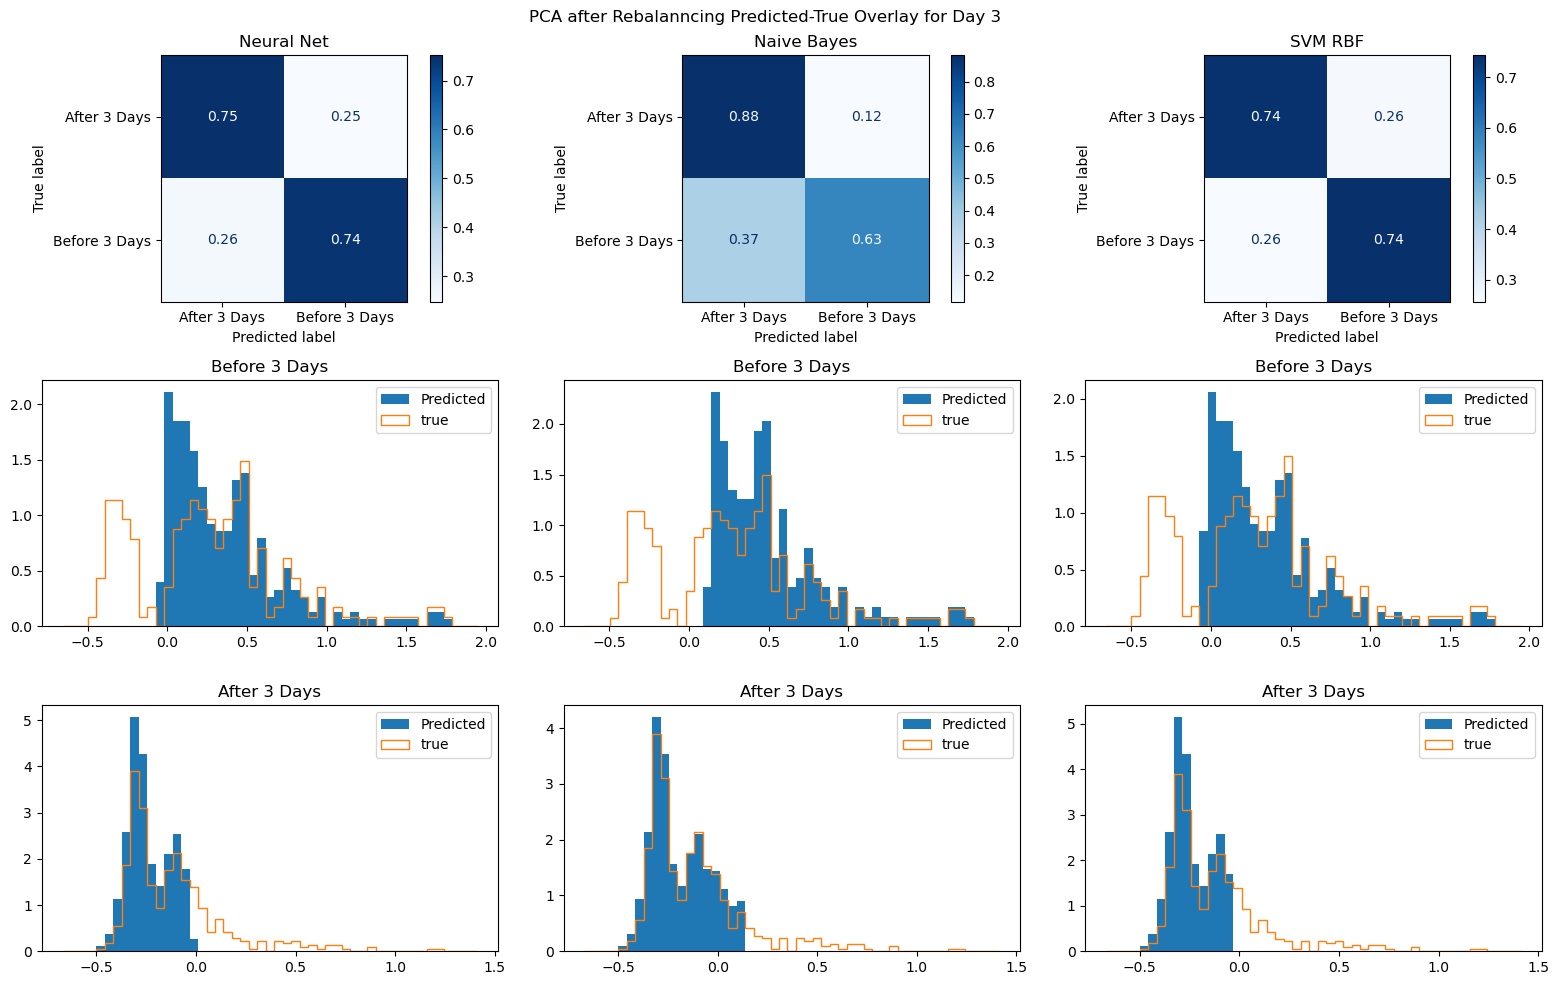

In [15]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(16,10))

clf = [clf1, clf2, clf3]

plt.suptitle("PCA after Rebalanncing Predicted-True Overlay for Day " + str(day))
for i in range(3):
    Predicted_true_overlay(clf[i], X_test_reduced, y_test, classifiers[i], label, i)
fig.tight_layout()

plt.show()

Time taken by Neural Net: 0.0002932548522949219
Time taken by Naive Bayes: 0.00013327598571777344
Time taken by SVM RBF: 0.09315991401672363


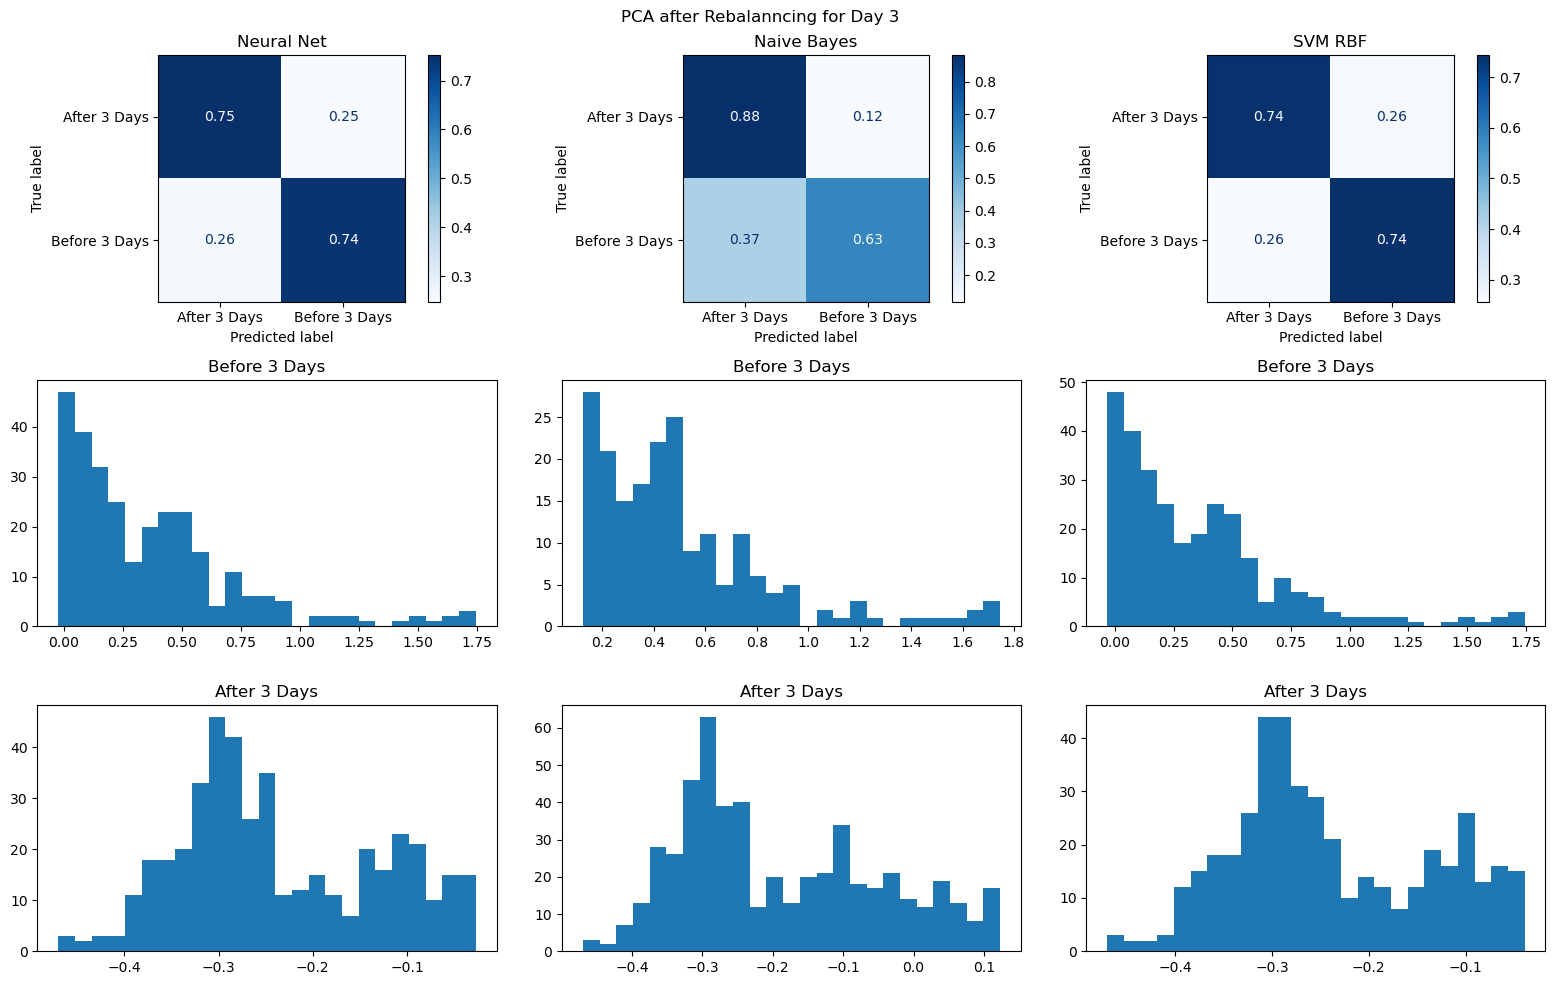

In [16]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(16,10))

clf = [clf1, clf2, clf3]

plt.suptitle("PCA after Rebalanncing for Day " + str(day))
for i in range(3):
    Analysis(clf[i], X_test_reduced, y_test, classifiers[i], label, i)
fig.tight_layout()

plt.show()